#Ejemplo de regresión con Keras + TensorFlow

## 1. Importar librerías necesarias
Lo primero que vamos a hacer es instalar librerías necesarias para dibujar la red gráficamente. Estas librerías no son imprescindibles, pero vamos a incorporarlas para utilizar una función de keras que nos permitirá ver de manera gráfica la red creada.

Después cargaremos las librerías que sí son imprescindibles, entre las que se encuentran: keras, tensorflow, numpy,...



In [ ]:
#Instalar librerias para dibujar la red gráficamente
!pip install pydot
!apt-get install graphviz

#Cargar librerias necesarias
import math
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


## 2. Generar los datos de entrenamiento

Ahora vamos a generar un conjunto de ejemplos para un problema de regresión. En concreto, nuestro problema tendrá ejemplos representados en $\mathbb{R}^2$. El valor real de estos ejemplos vendrá dado por la función $y=cos(x_0)+sin(x_1)$.

Esta función es claramente **no lineal**



In [ ]:
seed = 2032  # semilla de números aleatorios
NE = 5000  # se van a generar NE ejemplos

np.random.seed(seed)  # se inicializalizan los números aleatorios

# Generar una matriz de NE filas y 2 columnas con datos uniformes entre -5 y 5
laX = np.random.uniform(-5, 5, size=[NE, 2])

laY = np.zeros((NE, 1)) # Reservar espacio para la Y

# Rellenar el vector de la Y
for i in range(NE):
    laY[i] = math.cos(laX[i, 0])+math.sin(laX[i, 1])

print(laX)
print(laY)

[[ 4.5557887   3.84923263]
 [-2.22296771  2.30424712]
 [ 0.9677073  -2.77795226]
 ...
 [ 3.52344383 -2.2835793 ]
 [-2.81862311  4.66132362]
 [ 4.81409483  1.67149958]]
[[-0.8060032 ]
 [ 0.13595516]
 [ 0.21151034]
 ...
 [-1.68452131]
 [-1.94699356]
 [ 1.09646431]]


## 3. Crear el modelo (modelo lineal)
Lo primero que vamos a hacer es crear una red sin capas ocultas. Esta red se conoce como perceptrón lineal y sólo es capaz de resolver problemas lineales.

**Lee los comentarios del código detenidamente para entender lo que se está haciendo.**

*En la web de tensorflow puedes encontar tutoriales detallados*

Fíjate que la línea **model.summary()** imprime una representación en modo texto de la red y además indica el número de parámetros que se deben aprender en cada capa. En este caso hay una sola capa y los parámetros que hay que aprender son 3: los dos coeficientes que se multiplicarán por las entradas y el término independiente.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output_layer (Dense)        (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


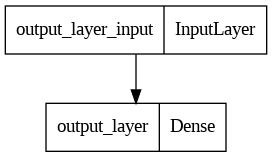

In [ ]:
""" SE DEFINE LA RED """
tf.keras.utils.set_random_seed(seed) # Fijar semilla del keras/tensorflow

n_input = 2      # Celdas en la capa de entrada (variables de entrada)
n_output = 1     # Celdas en la capa de salida (un valor numérico)

# Definir las capas del modelo
model = Sequential()
model.add(Dense(n_output, input_dim=n_input, name="output_layer"))

# Como se puede ver, se crea un modelo secuencial donde cada capa añadida recibe
# como entrada la salida de la anterior.
# La dimensión de la entrada siempre se define en la primera capa del modelo
# (parámetro input_dim) => model.add(Dense(n_output, input_dim=n_input, name="output_layer"))

# Existe también una forma "funcional" de crear modelos. En este caso sería:
# in_layer = Input(shape =(n_input,))
# out_layer = Dense(n_output, name="out_layer")(in_layer)
#
# model = Model(inputs = [in_layer], outputs = [out_layer])

""" SELECCIONAR OPTIMIZADOR E INICIALIZAR PARÁMETROS """
# Learning rate del modelo. Es el alpha que multiplicará a la derivada cuando
# se va a hacer la modificación de los parámetros que se aprenden.
learning_rate = 0.001

# Definir el optimizador a utilizar (SGD, descenso del gradiente estocástico)
# Consulta la ayuda para ver qué otros optimizadores hay
sgd = SGD(learning_rate=learning_rate)

# Compilar el modelo indicando la función de pérdida (loss) y el optimizador
model.compile(loss='mean_squared_error', optimizer=sgd )

""" SE VISUALIZA EL MODELO """
# Imprimir en modo texto finalmente el resumen/arquitectura de nuestro modelo
# Esta información permite conocer el número de parámetros que se han de aprender
model.summary()

# Obtener un fichero con la representación gráfica del modelo
plot_model(model, to_file='model.png')
# Después de ejecutar esta línea se genera el fichero 'model.png'. Para poder
# verlo, tienes que ir a la parte izquierda, acceder a la pestaña 'Archivos' y
# 'actualizar', aparecerá entonces el archivo y podrás verlo (doble click sobre
# el fichero 'model.png' o click con el botón derecho para descargarlo)


## 4. Entrenar el modelo
Una vez que ya hemos definido cómo va a ser nuestro modelo, vamos a entrenarlo para buscar los parámetros que hagan mínima la función de pérdida.

Para ello utilizaremos el método **fit**. Necesita que le suministremos los ejemplos (laX, laY), el tamaño del *batch* y el número de *epochs*.

El número de epochs es el número de veces que el algoritmo va a ver los ejemplos durante el entrenamiento.

El tamaño del batch es el número de ejemplos que se van a utilizar en cada actualización de los parámetros.

En el código vemos que elegimos como tamaño de batch 128. Como tenemos 5000 ejemplos y 5000/128=40, esto quiere decir que en 40 actualizaciones de los parámetros llegamos a los 5000 ejemplos, lo que completaría una epoch. Como le indicamos en el código que queremos 200 epochs, estaremos permitiendo que el algoritmo haga en total 40x200=8000 actualizaciones.

Con **verbose=2** le pedimos que nos muestre el error al finalizar cada epoch.

Fíjate que lo que retorna fit lo almacenamos en una variable que llamamos history. Más adelante la utilizaremos.

In [ ]:
batch = 128    # Tamaño del batch
n_epochs = 200 # Número de epochs

#Entrenar el modelo a partir de los ejemplos de TRAIN creados en el punto 2
history = model.fit(laX, laY, batch_size=batch, epochs=n_epochs, verbose=2)

Epoch 1/200
40/40 - 6s - loss: 6.0136 - 6s/epoch - 158ms/step
Epoch 2/200
40/40 - 0s - loss: 2.2391 - 128ms/epoch - 3ms/step
Epoch 3/200
40/40 - 0s - loss: 1.2852 - 144ms/epoch - 4ms/step
Epoch 4/200
40/40 - 0s - loss: 1.0368 - 208ms/epoch - 5ms/step
Epoch 5/200
40/40 - 0s - loss: 0.9694 - 179ms/epoch - 4ms/step
Epoch 6/200
40/40 - 0s - loss: 0.9486 - 198ms/epoch - 5ms/step
Epoch 7/200
40/40 - 0s - loss: 0.9428 - 139ms/epoch - 3ms/step
Epoch 8/200
40/40 - 0s - loss: 0.9399 - 91ms/epoch - 2ms/step
Epoch 9/200
40/40 - 0s - loss: 0.9376 - 85ms/epoch - 2ms/step
Epoch 10/200
40/40 - 0s - loss: 0.9359 - 81ms/epoch - 2ms/step
Epoch 11/200
40/40 - 0s - loss: 0.9346 - 78ms/epoch - 2ms/step
Epoch 12/200
40/40 - 0s - loss: 0.9335 - 76ms/epoch - 2ms/step
Epoch 13/200
40/40 - 0s - loss: 0.9326 - 75ms/epoch - 2ms/step
Epoch 14/200
40/40 - 0s - loss: 0.9316 - 85ms/epoch - 2ms/step
Epoch 15/200
40/40 - 0s - loss: 0.9308 - 78ms/epoch - 2ms/step
Epoch 16/200
40/40 - 0s - loss: 0.9302 - 75ms/epoch - 2ms/

##5. Función para dibujar la gráfica del error
Tras realizar el entrenamiento con fit, almacenamos lo que retorna ese método en una variable que llamamos history.

Definimos ahora la función **plot_history** que recibiendo lo retornado por fit, crea un gráfico en el que se ve la evolución del error que se está minimizando en función de la epoch en la que se está.

-- Mínimo error TRAIN: 0.926414
      Media 10 últimas epochs: ** 0.926538 **
      Desv. 10 últimas epochs: 0.000042


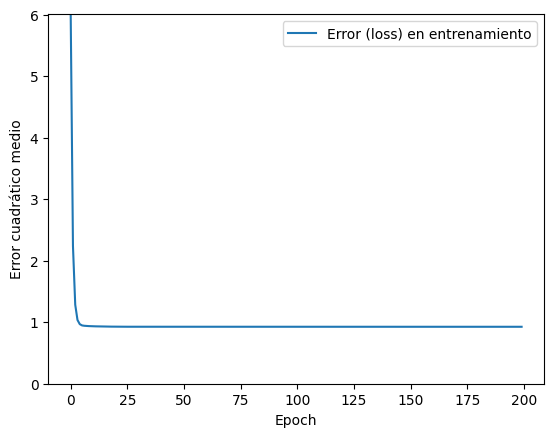

In [ ]:
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Error cuadrático medio')
  plt.plot(history.epoch, np.array(history.history['loss']),
           label='Error (loss) en entrenamiento')
  plt.legend()
  plt.ylim([0, max(1,max(np.array(history.history['loss'])))])

plot_history(history)
traza_train = np.array(history.history['loss'])
print("-- Mínimo error TRAIN: {:.6f}".format(min(traza_train)))
print("      Media 10 últimas epochs: ** {:.6f} **".format(np.mean(traza_train[-10:])))
print("      Desv. 10 últimas epochs: {:.6f}".format(np.std(traza_train[-10:])))


##6. Crear un modelo no lineal
El modelo anterior tiene una limitación muy grande: es un modelo lineal y eso le impide adaptarse de manera apropiada para resolver problemas no lineales.

Aun así, logra bajar el error hasta 0.926.

Vamos a ver ahora lo que sucede si creamos un modelo no lineal. Para ello vamos a incluir una capa oculta que tenga como función de activación la función **ReLU**.

Observa con detenimiento cómo se añade la capa, ya que tendrás posteriormente que añadir más capas.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1_layer (Dense)       (None, 10)                30        
                                                                 
 output_layer (Dense)        (None, 1)                 11        
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


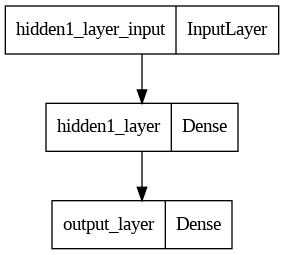

In [ ]:
""" SE DEFINE LA RED """
tf.keras.utils.set_random_seed(seed) # Fijar semilla del keras/tensorflow

n_input = 2      # Celdas en la capa de entrada (variables de entrada)
n_hidden1 = 10   # Celdas en la capa oculta
n_output = 1     # Celdas en la capa de salida (un valor numérico)

# Definir las capas del modelo
model = Sequential()
model.add(Dense(n_hidden1, input_dim=n_input, activation='relu',
                name="hidden1_layer"))
model.add(Dense(n_output,name="output_layer"))

# Como se puede ver, se crea un modelo secuencial donde cada capa añadida recibe
# como entrada la salida de la anterior.
# La dimensión de la entrada siempre se define en la primera capa del modelo
# (parámetro input_dim) => model.add(Dense(n_hidden1, input_dim=n_input, name="hidden1_layer"))


# Existe también una forma "funcional" de crear modelos. En este caso sería:
# in_layer = Input(shape =(n_input,))
# hidden_layer = Dense(n_hidden1, name="hidden1_layer",activation='relu')(in_layer)
# out_layer = Dense(n_output, name="out_layer")(hidden_layer)
#
# model = Model(inputs = [in_layer], outputs = [out_layer])

""" SE DEFINE EL MODELO """

# Learning rate del modelo. Es el alpha que multiplicará a la derivada cuando
# se va a hacer la modificación de los parámetros que se aprenden.
learning_rate = 0.001

# Definir el optimizador a utilizar (SGD, descenso del gradiente estocástico)
sgd = SGD(lr=learning_rate)

# Compilar el modelo indicando la función de pérdida (loss) y el optimizador
model.compile(loss='mean_squared_error', optimizer=sgd )

""" SE VISUALIZA EL MODELO """

# Imprimir en modo texto finalmente el resumen/arquitectura de nuestro modelo
# Esta información permite conocer cuántos parámetros  se han de aprender
model.summary()

# Obtener un fichero con la representación gráfica del modelo
plot_model(model, to_file='model.png')
# Después de ejecutar esta línea se genera el fichero 'model.png'. Para poder
# verlo, tienes que ir a la parte izquierda, acceder a la pestaña 'Archivos' y
# 'actualizar', aparecerá entonces el archivo y podrás verlo (doble click sobre
# el fichero 'model.png' o click con el botón derecho para descargarlo)

##7. Y lo ejecutamos
Ponemos **verbose=0** y así no tendremos que hacer tanto scroll. Eso sí, el resultado final tardará en aparecer unos segundos.

-- Mínimo error TRAIN: 0.034841
      Media 10 últimas epochs: ** 0.036311 **
      Desv. 10 últimas epochs: 0.000739


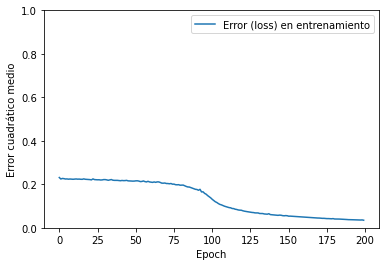

In [ ]:
#Entrenar el modelo a partir de los ejemplos de TRAIN creados en el punto 2
history = model.fit(laX, laY, batch_size=batch, epochs=n_epochs, verbose=0 )

plot_history(history)
traza_train = np.array(history.history['loss'])
print("-- Mínimo error TRAIN: {:.6f}".format(min(traza_train)))
print("      Media 10 últimas epochs: ** {:.6f} **".format(np.mean(traza_train[-10:])))
print("      Desv. 10 últimas epochs: {:.6f}".format(np.std(traza_train[-10:])))

Como puedes ver, el error se ha hecho más pequeño. Esto es normal, ya que una red con una capa oculta y función de activación ReLU ya es capaz de aprender funciones no lineales.

##8. Crea tú ahora una red con 2 capas ocultas
Debes crear una red con 2 capas ocultas. La primera con 6 celdas y la segunda con 4 celdas.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1_layer (Dense)       (None, 6)                 18        
                                                                 
 hidden2_layer (Dense)       (None, 4)                 28        
                                                                 
 output_layer (Dense)        (None, 1)                 5         
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


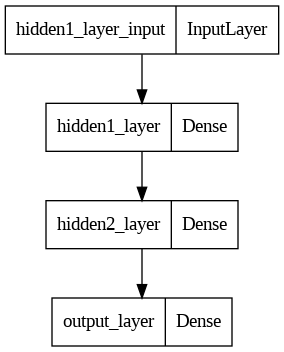

In [ ]:
""" SE DEFINE LA RED """
tf.keras.utils.set_random_seed(seed) # Fijar semilla del keras/tensorflow

n_hidden1 = 6
n_hidden2 = 4

model = Sequential()
model.add(Dense(n_hidden1, input_dim=n_input, activation='relu',
                name="hidden1_layer"))
model.add(Dense(n_hidden2, name="hidden2_layer"))
model.add(Dense(n_output,name="output_layer"))

""" SE DEFINE EL MODELO """

# Learning rate del modelo. Es el alpha que multiplicará a la derivada cuando
# se va a hacer la modificación de los parámetros que se aprenden. En el vídeo
# del "Descenso del gradiente" se explica su función
learning_rate = 0.001

# Definir el optimizador a utilizar (SGD, descenso del gradiente estocástico)
sgd = SGD(lr=learning_rate)

# Compilar el modelo indicando la función de pérdida (loss) y el optimizador
model.compile(loss='mean_squared_error', optimizer=sgd )

""" SE VISUALIZA EL MODELO """

# Imprimir en modo texto finalmente el resumen/arquitectura de nuestro modelo
# Esta información permite conocer el número de parámetros que se han de aprender
model.summary()

# Obtener un fichero con la representación gráfica del modelo
plot_model(model, to_file='model.png')
# Después de ejecutar esta línea se genera el fichero 'model.png'. Para poder
# verlo, tienes que ir a la parte izquierda, acceder a la pestaña 'Archivos' y
# 'actualizar', aparecerá entonces el archivo y podrás verlo (doble click sobre
# el fichero 'model.png' o click con el botón derecho para descargarlo)

Ejecuta el siguiente código para ver el rendimiento de la red que acabas de crear.

-- Mínimo error TRAIN: 0.174914
      Media 10 últimas epochs: ** 0.189470 **
      Desv. 10 últimas epochs: 0.009168


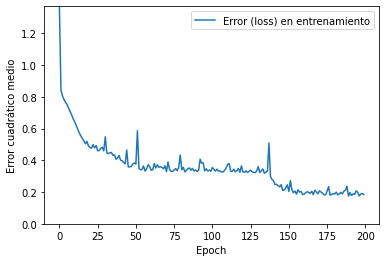

In [ ]:
#Entrenar el modelo a partir de los ejemplos de TRAIN creados en el punto 2
history = model.fit(laX, laY, batch_size=batch, epochs=n_epochs, verbose=0 )

plot_history(history)
traza_train = np.array(history.history['loss'])
print("-- Mínimo error TRAIN: {:.6f}".format(min(traza_train)))
print("      Media 10 últimas epochs: ** {:.6f} **".format(np.mean(traza_train[-10:])))
print("      Desv. 10 últimas epochs: {:.6f}".format(np.std(traza_train[-10:])))

Puedes probar otras configuraciones de red para intentar obtener mejores resultados.

-- Mínimo error TRAIN: 0.033086
      Media 10 últimas epochs: ** 0.034233 **
      Desv. 10 últimas epochs: 0.000754


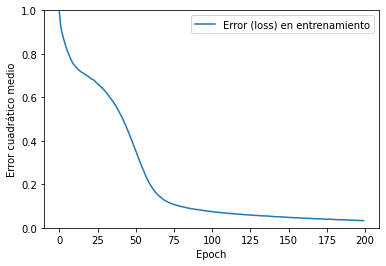

In [ ]:
n_hidden1 = 80
n_hidden2 = 60

model = Sequential()
model.add(Dense(n_hidden1, input_dim=n_input, activation='relu',
                name="hidden1_layer"))
model.add(Dense(n_hidden2, activation='sigmoid', name='hidden2_layer'))
model.add(Dense(n_output,name="output_layer"))

""" SE DEFINE EL MODELO """

# Learning rate del modelo. Es el alpha que multiplicará a la derivada cuando
# se va a hacer la modificación de los parámetros que se aprenden. En el vídeo
# del "Descenso del gradiente" se explica su función
learning_rate = 0.001

# Definir el optimizador a utilizar (SGD, descenso del gradiente estocástico)
sgd = SGD(lr=learning_rate)

# Compilar el modelo indicando la función de pérdida (loss) y el optimizador
model.compile(loss='mean_squared_error', optimizer=sgd )

plot_model(model, to_file='model.png')

history = model.fit(laX, laY, batch_size=batch, epochs=n_epochs, verbose=0 )

plot_history(history)
traza_train = np.array(history.history['loss'])
print("-- Mínimo error TRAIN: {:.6f}".format(min(traza_train)))
print("      Media 10 últimas epochs: ** {:.6f} **".format(np.mean(traza_train[-10:])))
print("      Desv. 10 últimas epochs: {:.6f}".format(np.std(traza_train[-10:])))